# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
import keras.backend as K
from skimage import exposure
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from glob import glob
import pickle
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [2]:
print('GPU avalible: ' + str(len(tf.config.get_visible_devices('GPU')) > 0))

GPU avalible: True


In [3]:
SEED = 33
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data preparation.

In [4]:
imgs = glob(f'../*/*/*/frame_*_endo.png')
masks = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')

assert len(imgs) == len(masks)

print(f'Number of samples: {str(len(masks))}')

Number of samples: 8080


In [5]:
HEIGHT, WIDTH = 64, 128
N = len(masks)
CLASS_WEIGHTS = np.array([2.45780159e-01, 2.24610010e-01, 2.24005501e-01, 1.87119512e-02,
 1.46965911e-01, 2.54698498e-02, 2.35562466e-02, 4.28713053e-03,
 3.93593665e-04, 1.38500705e-02, 6.78984614e-02, 1.01436955e-04,
 4.36967906e-03])


In [6]:
X, y = [], []

for img, mask in zip(imgs, masks):
    img = cv2.imread(img)
    img = img[10:-10, 10:-10,:]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (WIDTH, HEIGHT))
    img = img / 255
    X.append(img)

    mask = cv2.imread(mask)
    mask = mask[10:-10, 10:-10,:]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (WIDTH, HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)

    y.append(mask)

X = np.array(X)
y = np.array(y)

assert X.shape[0:-1] == y.shape[0:-1]

X.shape, y.shape

((8080, 64, 128, 3), (8080, 64, 128, 1))

In [7]:
def dump_data(X_data, y_data):
    X_file = open('../resources/X_dump.p', 'ab')
    y_file = open('../resources/y_dump.p', 'ab')

    pickle.dump(X_data, X_file)
    pickle.dump(y_data, y_file)

    X_file.close()
    y_file.close()

# dump_data(X, y)

In [8]:
def load_data():
    X_file = open('../resources/X_dump.p', 'rb')
    y_file = open('../resources/y_dump.p', 'rb')

    X_data = pickle.load(X_file)
    y_data = pickle.load(y_file)

    X_file.close()
    y_file.close()
    return X_data, y_data

# X, y = load_data()

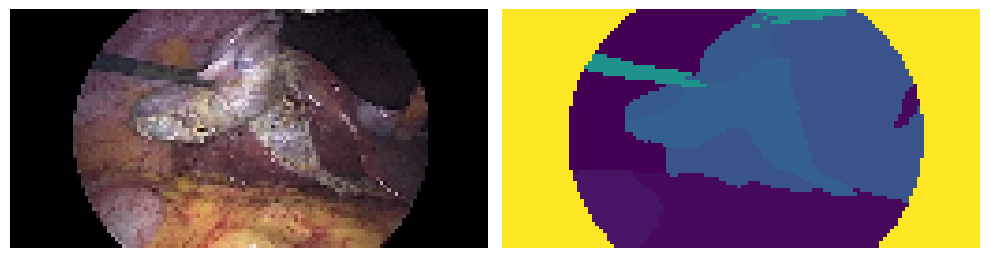

In [9]:
idx = random.randint(0, len(X)-1)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[idx])
plt.axis("off")
plt.subplot(122)
plt.imshow(y[idx])
plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]

y_encoded = np.zeros((N, HEIGHT, WIDTH, 1), dtype=np.uint8)

for i, label in enumerate(labels):
    y_encoded[np.all(label == y, axis=-1)] = i + 1
 
y = tf.keras.utils.to_categorical(y_encoded, num_classes=13)

In [11]:
# dump_data(X, y)
# X, y = load_data()
np.unique(y_encoded[idx])

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10], dtype=uint8)

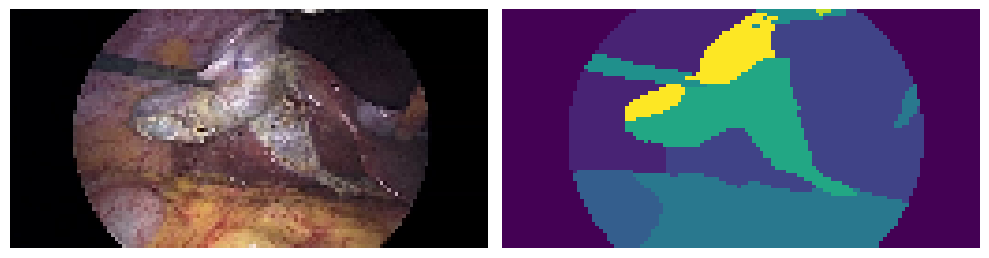

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[idx])
plt.axis("off")
plt.subplot(122)
plt.imshow(tf.argmax(y[idx], axis=-1))
plt.axis("off")
plt.tight_layout()
plt.show()

## U-Net

In [13]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = tf.keras.layers.MaxPool2D(2)(f)
   p = tf.keras.layers.BatchNormalization()(p)
   p = tf.keras.layers.Dropout(0.2)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = tf.keras.layers.concatenate([x, conv_features])
   # dropout
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.Dropout(0.2)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

def build_unet_model(n_filters=64, n_classes=2):
   # inputs
   inputs = tf.keras.layers.Input(shape=(HEIGHT,WIDTH,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, n_filters)
   # 2 - downsample
   f2, p2 = downsample_block(p1, n_filters*2)
   # 3 - downsample
   f3, p3 = downsample_block(p2, n_filters*4)
   # 4 - downsample
   f4, p4 = downsample_block(p3, n_filters*8)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, n_filters*16)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, n_filters*8)
   # 7 - upsample
   u7 = upsample_block(u6, f3, n_filters*4)
   # 8 - upsample
   u8 = upsample_block(u7, f2, n_filters*2)
   # 9 - upsample
   u9 = upsample_block(u8, f1, n_filters)

   # outputs
   
   activation = 'sigmoid' if n_classes == 2 else 'softmax'
   outputs = tf.keras.layers.Conv2D(n_classes, 1, padding="same", activation=activation)(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [14]:
def dice_coeficient(y_true, y_pred):
    T = tf.keras.backend.flatten(y_true)
    P = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(T * P)
    dice = (2 * intersection) / (tf.keras.backend.sum(T + P))
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coeficient(y_true, y_pred)

def tversky(y_true, y_pred, smooth=1, alpha=0.8):
    T = tf.keras.backend.flatten(y_true)
    P = tf.keras.backend.flatten(y_pred)
    TP = tf.keras.backend.sum(T * P)
    FN = tf.keras.backend.sum(T * (1 - P))
    FP = tf.keras.backend.sum((1 - T) * P)
    return (TP + smooth) / (TP + alpha * FN + (1 - alpha) * FP + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return tf.keras.backend.pow((1 - tv), gamma)

def generalized_dice_coeff(y_true, y_pred, smooth=1e-9):
    Ncl = y_pred.shape[-1]
    w = np.zeros((Ncl,))
    w = K.sum(y_true, (0,1,2))
    w = 1 / (w ** 2 + smooth)

    y_pred = tf.nn.softmax(y_pred)

    # Compute gen dice coef:
    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0,1,2))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0,1,2))
    denominator = K.sum(denominator)

    return 2. * (numerator + smooth) / (denominator + smooth)


def generalized_dice_loss(y_true, y_pred):
    return 1. - generalized_dice_coeff(y_true, y_pred)

In [15]:
unet_model = build_unet_model(n_filters=32, n_classes=13)
# unet_model.load_weights('../models/u-net_39-0.22_tversky_loss.hdf5')
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss=sm.losses.DiceLoss(class_weights=CLASS_WEIGHTS),
    metrics=[tf.metrics.MeanIoU(num_classes=13), dice_coeficient]
)

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 64, 32)   0           ['conv2d_1[0][0]']           

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43) 

print('\n\t EVALUATION\n')
unet_model.evaluate(
    X_test, 
    y_test,
    batch_size=32
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '../models/u-net_train_DiceLoss_Class_Weights.hdf5',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

print('\n\t TRAINING\n')

model_history = unet_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=4,
    validation_data=(X_test, y_test),
    use_multiprocessing=True,
    callbacks=[checkpoint],
    verbose=1
)

unet_model.save_weights('../models/u-net_DiceLoss_Class_Weights.hdf5')


	 EVALUATION

51/51 [==============================] - 11s 42ms/step - loss: 0.9917 - mean_io_u: 0.4615 - dice_coeficient: 0.0828

	 TRAINING

Epoch 1/100
1616/1616 [==============================] - ETA: 0s - loss: 0.9519 - mean_io_u: 0.4616 - dice_coeficient: 0.6296
Epoch 1: val_loss improved from inf to 0.94419, saving model to ../models\u-net_train_DiceLoss_Class_Weights.hdf5
1616/1616 [==============================] - 40s 23ms/step - loss: 0.9519 - mean_io_u: 0.4616 - dice_coeficient: 0.6296 - val_loss: 0.9442 - val_mean_io_u: 0.4617 - val_dice_coeficient: 0.7600
Epoch 2/100
1614/1616 [============================>.] - ETA: 0s - loss: 0.9392 - mean_io_u: 0.4663 - dice_coeficient: 0.8196
Epoch 2: val_loss improved from 0.94419 to 0.94035, saving model to ../models\u-net_train_DiceLoss_Class_Weights.hdf5
1616/1616 [==============================] - 38s 23ms/step - loss: 0.9392 - mean_io_u: 0.4663 - dice_coeficient: 0.8196 - val_loss: 0.9403 - val_mean_io_u: 0.4693 - val_dice_coefi

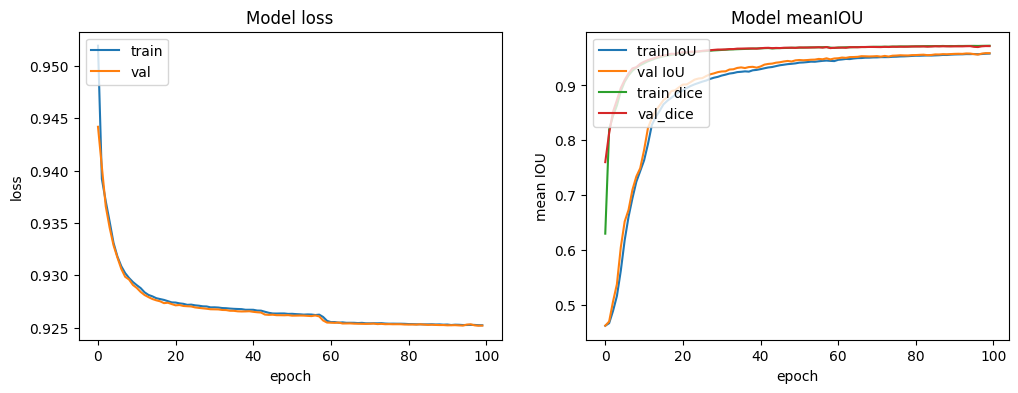

In [17]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(122)
plt.plot(model_history.history['mean_io_u'])
plt.plot(model_history.history['val_mean_io_u'])
plt.plot(model_history.history['dice_coeficient'])
plt.plot(model_history.history['val_dice_coeficient'])
plt.title('Model meanIOU')
plt.ylabel('mean IOU')
plt.xlabel('epoch')
# plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='upper left')

plt.show()

In [18]:
# unet_model = build_unet_model(n_filters=32, n_classes=13)
# unet_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0e-4), 
#     loss=dice_loss,
#     metrics=[tf.metrics.MeanIoU(num_classes=13), dice_coeficient]
# )

# unet_model.load_weights('../models/u-net_100epochs.hdf5')

In [19]:
pred = unet_model.predict(X_test)
pred = np.array(pred)
pred = tf.argmax(pred, axis=-1)

51/51 [==============================] - 2s 26ms/step


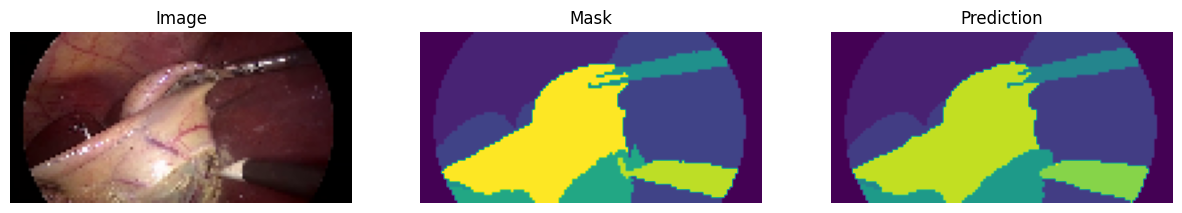

In [28]:
idx = random.randint(0, len(pred)-1)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(X_test[idx])
plt.title('Image')
plt.axis("off")

plt.subplot(132)
plt.imshow(tf.argmax(y_test[idx], axis=-1))
plt.title('Mask')
plt.axis("off")

plt.subplot(133)
plt.imshow(pred[idx])
plt.title('Prediction')
plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota